### imports

In [1]:
import time
import hrr_persistant_memory as hrr
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

### maze enviornment

In [2]:
# maze enviornment
#  l    42    r
# rg    32    gg
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4
#      - 8
#      -18

def maze(state):
    if state == -18:
        return ['up']
    if state == -8:
        return ['up', 'down']
    if state == 0:
        return ['right']
    if state == 1:
        return ['right', 'left']
    if state == 2:
        return ['right', 'up', 'left', 'down']
    if state == 3:
        return ['right', 'left']
    if state == 4:
        return ['left']
    if state == 12:
        return ['up', 'down']
    if state == 20:
        return ['right']
    if state == 21:
        return ['right', 'left']
    if state == 22:
        return ['right', 'up', 'left', 'down']
    if state == 23:
        return ['right', 'left']
    if state == 24:
        return ['left']
    if state == 32:
        return ['up', 'down']
    if state == 42:
        return ['down']

### hyperparameters

In [3]:
bias = 1.0
reward = 1.0

gamma = 0.5
alpha = 0.1
lambd = 0.0
epsilon = 0.05

states = 12
episodes = 10000

hrr_size = 1024
non_goal_states = 0

# drop in states
drop_in_states = [0]
gates = ['open', 'closed']

### gate functions

In [4]:
def encode_gate(state, signal, w_m, gate_action):
    string = 'state_'  + str(state) + "*" + \
             'signal_' + str(signal) + "*" + \
             'w_m_' + str(w_m) + "*" + \
             'gate_action_' + str(gate_action)
    encoded = np.array([memory.encode(string)])
    return(encoded)

In [5]:
# input gate

def q_input_gate(state, signal, w_m):
    max_value = -99999
    
    if np.random.random() < epsilon:
        gate = np.random.choice(gates)
        hrr = encode_gate(state, signal, w_m, gate)
        value = model_input_gate.predict(hrr)[0,0] + bias
        return value, hrr, gate
    else:
        for gate_action in gates:
            hrr = encode_gate(state, signal, w_m, gate_action)
            value = model_input_gate.predict(hrr)[0,0] + bias
            if value > max_value:
                max_value = value
                max_hrr = hrr
                max_gate = gate_action
        return  max_value, max_hrr, max_gate

In [6]:
# output gate

def q_output_gate(state, signal, w_m):
    max_value = -99999
    
    if np.random.random() < epsilon:
        gate = np.random.choice(gates)
        hrr = encode_gate(state, signal, w_m, gate)
        value = model_output_gate.predict(hrr)[0,0] + bias
        return value, hrr, gate
    else:
        for gate_action in gates:
            hrr = encode_gate(state, signal, w_m, gate_action)
            value = model_output_gate.predict(hrr)[0,0] + bias
            if value > max_value:
                max_value = value
                max_hrr = hrr
                max_gate = gate_action
        return  max_value, max_hrr, max_gate

In [7]:
# move gate

def encode_move(state, signal, w_m, phyical_action):
    string = 'state_'  + str(state) + "*" + \
             'signal_' + str(signal) + "*" + \
             'w_m_' + str(w_m) + "*" + \
             'phyical_action_' + str(phyical_action)
    encoded = np.array([memory.encode(string)])
    return(encoded)

def q_move(state, signal, w_m):
    max_value = -99999
    if np.random.random() < epsilon:
        phyical_move = np.random.choice(actions)
        hrr = encode_move(state, signal, w_m, phyical_move)
        value = model_move.predict(hrr)[0,0] + bias
        return value, hrr, phyical_move  
    else:
        for phyical_action in actions:
            hrr = encode_move(state, signal, w_m, phyical_action)
            value = model_move.predict(hrr)[0,0] + bias
            if value > max_value:
                max_value = value
                max_hrr = hrr
                max_action = phyical_action
        return  max_value, max_hrr, max_action

def q_move_max(state, signal, w_m):
    max_value = -99999
#     print(state, actions)
    for phyical_action in actions:    
        hrr = encode_move(state, signal, w_m, phyical_action)
        value = model_move.predict(hrr)[0,0] + bias
        if value > max_value:
            max_value = value
            max_hrr = hrr
            max_action = phyical_action
    return  max_value, max_hrr, max_action

### code is adapted to run multible times
#### this experement was run 1 time to run more just increase the number of runs below and change import hrr_persistant_memory to hrr

In [8]:
runs = 1
master = []
ep_count = []

# for run in range(runs):
#     master.append([])

for run in range(runs):   
    
    sub_optimal_steps =[]
    sub_optimal_average =[]
    
    memory = hrr.LTM(prefix="my_hrrs", N=hrr_size, normalized=True)
    
    model_input_gate = keras.models.Sequential()
    model_input_gate.add(keras.layers.Dense(1,input_shape=[hrr_size],use_bias=False))
    model_input_gate.compile(loss=keras.losses.mse,
                             optimizer=keras.optimizers.SGD(learning_rate=alpha),
                             metrics=['accuracy'])
    
    model_output_gate = keras.models.Sequential()
    model_output_gate.add(keras.layers.Dense(1,input_shape=[hrr_size],use_bias=False))
    model_output_gate.compile(loss=keras.losses.mse,
                              optimizer=keras.optimizers.SGD(learning_rate=alpha),
                              metrics=['accuracy'])
    
    model_move = keras.models.Sequential()
    model_move.add(keras.layers.Dense(1,input_shape=[hrr_size],use_bias=False))
    model_move.compile(loss=keras.losses.mse,
                       optimizer=keras.optimizers.SGD(learning_rate=alpha),
                       metrics=['accuracy'])
    
    color_arr = []
    
    start_time = time.time()

    for episode in range(episodes):

        # update every 100 episodes
        if (episode+1) % 100 == 0:
            so_far = (time.time() - start_time)
            print("\rrun:", run+1, "on:", episode+1, "in:", round(so_far, 2) , "seconds", end='')
            start_time = time.time()

        if episode > episodes/2:
            colors = ['red', 'green', 'purple']
        else:
            colors = ['red', 'green']
        
        current_state = 0 # np.random.choice(drop_in_states)       
        current_signal = np.random.choice(colors)
        color_arr.append(current_signal)

        if current_signal == 'red':
            goal_state = 20
        if current_signal == 'green':
            goal_state = 24
        if current_signal == 'purple':
            goal_state = 42

        # for record keeping suboptimal steps
        color_start = current_state

        # clear out working memory amd move content
        current_w_m = ''
        recall = 'not_remembering'

        for step in range(states):

            # set for same start
            if current_state == goal_state:
                if color_start == 0:
                    sub_optimal_steps.append(step - 6)
                break
            else:
                if step == (states-1):
                    sub_optimal_steps.append(states)

            actions = maze(current_state)

            if current_signal != '':

                # need to make this color
                back_up = current_signal
                current_signal = 'color'

                gate_value, \
                gate_hrr, \
                gate_action = q_input_gate(current_state, current_signal, recall)

                current_signal = back_up

                move_value, \
                move_hrr, \
                move_action = q_move(current_state, current_signal, recall)

                previous_state = current_state
                previous_gate_hrr = gate_hrr
                previous_move_value = move_value
                previous_move_hrr = move_hrr

                if gate_action == 'open':
                    current_w_m = current_signal
                    recall = 'remembering'

                current_signal = ''            

                # make move to next state      
                if (move_action == "left"):
                    current_state = (current_state-1)
                if (move_action == "right"):
                    current_state = (current_state+1)
                if (move_action == "up"):
                    current_state = (current_state+10)
                if (move_action == "down"):
                    current_state = (current_state-10)

                # now current_state is the next state so check new actions
                actions = maze(current_state)

                if current_state == goal_state:
                    target = reward
                else:
                    if recall == 'remembering':
                        _, _, gate_action = q_output_gate(current_state, current_signal, recall)
                    else:
                        gate_action = 'closed'

                    if gate_action == 'open':
                        save_recall = recall
                        recall = current_w_m
                        move_value, _, _ = q_move_max(current_state, current_signal, recall)
                        recall = save_recall
                    else:
                        move_value, _, _ = q_move_max(current_state, current_signal, recall)

                    target = non_goal_states + gamma * move_value

                model_input_gate.fit(previous_gate_hrr, [target-bias], verbose=0)

            else:                
                gate_value, \
                gate_hrr, \
                gate_action = q_output_gate(current_state, current_signal, recall)

                if gate_action == 'open':
                    recall = current_w_m
                    current_w_m = ''
                    move_value, \
                    move_hrr, \
                    move_action = q_move(current_state, current_signal, recall)
                    recall = 'memory_used'
                else:
                    move_value, \
                    move_hrr, \
                    move_action = q_move(current_state, current_signal, recall)

                previous_state = current_state
                previous_move_value = move_value
                previous_move_hrr = move_hrr
                previous_gate_hrr = gate_hrr

                if (move_action == "left"):
                    current_state = (current_state-1)
                if (move_action == "right"):
                    current_state = (current_state+1)
                if (move_action == "up"):
                    current_state = (current_state+10)
                if (move_action == "down"):
                    current_state = (current_state-10)

                actions = maze(current_state)

                if current_state == goal_state:
                    target = reward
                else:
                    if recall == 'remembering':
                        _, _, gate_action = q_output_gate(current_state, current_signal, recall)
                    else:
                        gate_action = 'closed'

                    if gate_action == 'open':
                        save_recall = recall
                        recall = current_w_m
                        move_value, _, _ = q_move_max(current_state, current_signal, recall)
                        recall = save_recall
                    else:
                        move_value, _, _ = q_move_max(current_state, current_signal, recall)

                    target = non_goal_states + gamma * move_value

                model_output_gate.fit(previous_gate_hrr, [target-bias], verbose=0)

            model_move.fit(previous_move_hrr, [target-bias], verbose=0)
            
    master.append(sub_optimal_steps)
    list_freq = (Counter(color_arr))
    ep_count.append(list_freq)

/opt/conda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-12-09 06:09:42.122185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 06:09:42.157515: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2021-12-09 06:09:42.185668: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300170000 Hz


run: 1 on: 10000 in: 20.35 seconds

### save all models

In [10]:
model_input_gate.save("model_input_gate.h5",save_format='h5')
model_output_gate.save("model_output_gate.h5",save_format='h5')
model_move.save("model_move.h5",save_format='h5')

In [11]:
ep_count

[Counter({'green': 4171, 'red': 4174, 'purple': 1655})]

### save all data

In [12]:
np.save('ep_count', ep_count)

In [13]:
arr = np.array(master)
new_arr = np.add(0, arr.sum(axis=0))/runs

In [14]:
final_arr = []
for i in range(len(new_arr)-99):
    final_arr.append(np.mean(new_arr[i:i+100]))

In [16]:
np.save('final_arr', final_arr)


# go to

#### i_maze_input_gate_output_gate_final_code_red_greed_purple_load notebook

### plots to make advisor happy

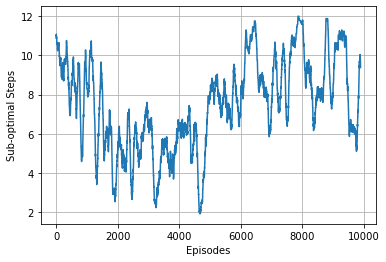

In [15]:
plt.plot(final_arr)
plt.grid(True)
plt.xlabel('Episodes')
plt.ylabel('Sub-optimal Steps')
# plt.savefig('red_green_purple.png')
plt.show()

### run model on each color to see what policy the agent learned
#### red below

In [34]:
current_state = 0       
current_signal = 'red'

if current_signal == 'red':
    goal_state = 20
if current_signal == 'green':
    goal_state = 24
if current_signal == 'purple':
    goal_state = 42

# clear out working memory amd move content
current_w_m = ''
recall = 'not_remembering'

for step in range(states):
    print(step, current_state)
    # set for same start
    if current_state == goal_state:
        if color_start == 0:
            sub_optimal_steps.append(step - 6)
        break
    else:
        if step == (states-1):
            sub_optimal_steps.append(states)

    actions = maze(current_state)

    if current_signal != '':

        # need to make this color
        back_up = current_signal
        current_signal = 'color'

        gate_value, \
        gate_hrr, \
        gate_action = q_input_gate(current_state, current_signal, recall)

        current_signal = back_up

        move_value, \
        move_hrr, \
        move_action = q_move(current_state, current_signal, recall)

        previous_state = current_state
        previous_gate_hrr = gate_hrr
        previous_move_value = move_value
        previous_move_hrr = move_hrr

        if gate_action == 'open':
            current_w_m = current_signal
            recall = 'remembering'

        current_signal = ''            

        # make move to next state      
        if (move_action == "left"):
            current_state = (current_state-1)
        if (move_action == "right"):
            current_state = (current_state+1)
        if (move_action == "up"):
            current_state = (current_state+10)
        if (move_action == "down"):
            current_state = (current_state-10)

        # now current_state is the next state so check new actions
        actions = maze(current_state)

        if current_state == goal_state:
            target = reward
        else:
            if recall == 'remembering':
                _, _, gate_action = q_output_gate(current_state, current_signal, recall)
            else:
                gate_action = 'closed'

            if gate_action == 'open':
                save_recall = recall
                recall = current_w_m
                move_value, _, _ = q_move_max(current_state, current_signal, recall)
                recall = save_recall
            else:
                move_value, _, _ = q_move_max(current_state, current_signal, recall)

            target = non_goal_states + gamma * move_value

    else:                
        gate_value, \
        gate_hrr, \
        gate_action = q_output_gate(current_state, current_signal, recall)

        if gate_action == 'open':
            recall = current_w_m
            current_w_m = ''
            move_value, \
            move_hrr, \
            move_action = q_move(current_state, current_signal, recall)
            recall = 'memory_used'
        else:
            move_value, \
            move_hrr, \
            move_action = q_move(current_state, current_signal, recall)

        previous_state = current_state
        previous_move_value = move_value
        previous_move_hrr = move_hrr
        previous_gate_hrr = gate_hrr

        if (move_action == "left"):
            current_state = (current_state-1)
        if (move_action == "right"):
            current_state = (current_state+1)
        if (move_action == "up"):
            current_state = (current_state+10)
        if (move_action == "down"):
            current_state = (current_state-10)

        actions = maze(current_state)

        if current_state == goal_state:
            target = reward
        else:
            if recall == 'remembering':
                _, _, gate_action = q_output_gate(current_state, current_signal, recall)
            else:
                gate_action = 'closed'

            if gate_action == 'open':
                save_recall = recall
                recall = current_w_m
                move_value, _, _ = q_move_max(current_state, current_signal, recall)
                recall = save_recall
            else:
                move_value, _, _ = q_move_max(current_state, current_signal, recall)

            target = non_goal_states + gamma * move_value

0 0
1 1
2 2
3 12
4 22
5 32
6 22
7 23
8 24
9 23
10 24
11 23


##### we can see red did not behave well








#### green below

In [35]:
current_state = 0       
current_signal = 'green'

if current_signal == 'red':
    goal_state = 20
if current_signal == 'green':
    goal_state = 24
if current_signal == 'purple':
    goal_state = 42

# clear out working memory amd move content
current_w_m = ''
recall = 'not_remembering'

for step in range(states):
    print(step, current_state)
    # set for same start
    if current_state == goal_state:
        if color_start == 0:
            sub_optimal_steps.append(step - 6)
        break
    else:
        if step == (states-1):
            sub_optimal_steps.append(states)

    actions = maze(current_state)

    if current_signal != '':

        # need to make this color
        back_up = current_signal
        current_signal = 'color'

        gate_value, \
        gate_hrr, \
        gate_action = q_input_gate(current_state, current_signal, recall)

        current_signal = back_up

        move_value, \
        move_hrr, \
        move_action = q_move(current_state, current_signal, recall)

        previous_state = current_state
        previous_gate_hrr = gate_hrr
        previous_move_value = move_value
        previous_move_hrr = move_hrr

        if gate_action == 'open':
            current_w_m = current_signal
            recall = 'remembering'

        current_signal = ''            

        # make move to next state      
        if (move_action == "left"):
            current_state = (current_state-1)
        if (move_action == "right"):
            current_state = (current_state+1)
        if (move_action == "up"):
            current_state = (current_state+10)
        if (move_action == "down"):
            current_state = (current_state-10)

        # now current_state is the next state so check new actions
        actions = maze(current_state)

        if current_state == goal_state:
            target = reward
        else:
            if recall == 'remembering':
                _, _, gate_action = q_output_gate(current_state, current_signal, recall)
            else:
                gate_action = 'closed'

            if gate_action == 'open':
                save_recall = recall
                recall = current_w_m
                move_value, _, _ = q_move_max(current_state, current_signal, recall)
                recall = save_recall
            else:
                move_value, _, _ = q_move_max(current_state, current_signal, recall)

            target = non_goal_states + gamma * move_value

    else:                
        gate_value, \
        gate_hrr, \
        gate_action = q_output_gate(current_state, current_signal, recall)

        if gate_action == 'open':
            recall = current_w_m
            current_w_m = ''
            move_value, \
            move_hrr, \
            move_action = q_move(current_state, current_signal, recall)
            recall = 'memory_used'
        else:
            move_value, \
            move_hrr, \
            move_action = q_move(current_state, current_signal, recall)

        previous_state = current_state
        previous_move_value = move_value
        previous_move_hrr = move_hrr
        previous_gate_hrr = gate_hrr

        if (move_action == "left"):
            current_state = (current_state-1)
        if (move_action == "right"):
            current_state = (current_state+1)
        if (move_action == "up"):
            current_state = (current_state+10)
        if (move_action == "down"):
            current_state = (current_state-10)

        actions = maze(current_state)

        if current_state == goal_state:
            target = reward
        else:
            if recall == 'remembering':
                _, _, gate_action = q_output_gate(current_state, current_signal, recall)
            else:
                gate_action = 'closed'

            if gate_action == 'open':
                save_recall = recall
                recall = current_w_m
                move_value, _, _ = q_move_max(current_state, current_signal, recall)
                recall = save_recall
            else:
                move_value, _, _ = q_move_max(current_state, current_signal, recall)

            target = non_goal_states + gamma * move_value

0 0
1 1
2 2
3 12
4 22
5 32
6 22
7 23
8 24


##### we can see green is sub-optimal but still solving the task








#### purple below

In [36]:
current_state = 0       
current_signal = 'purple'

if current_signal == 'red':
    goal_state = 20
if current_signal == 'green':
    goal_state = 24
if current_signal == 'purple':
    goal_state = 42

# clear out working memory amd move content
current_w_m = ''
recall = 'not_remembering'

for step in range(states):
    print(step, current_state)
    # set for same start
    if current_state == goal_state:
        if color_start == 0:
            sub_optimal_steps.append(step - 6)
        break
    else:
        if step == (states-1):
            sub_optimal_steps.append(states)

    actions = maze(current_state)

    if current_signal != '':

        # need to make this color
        back_up = current_signal
        current_signal = 'color'

        gate_value, \
        gate_hrr, \
        gate_action = q_input_gate(current_state, current_signal, recall)

        current_signal = back_up

        move_value, \
        move_hrr, \
        move_action = q_move(current_state, current_signal, recall)

        previous_state = current_state
        previous_gate_hrr = gate_hrr
        previous_move_value = move_value
        previous_move_hrr = move_hrr

        if gate_action == 'open':
            current_w_m = current_signal
            recall = 'remembering'

        current_signal = ''            

        # make move to next state      
        if (move_action == "left"):
            current_state = (current_state-1)
        if (move_action == "right"):
            current_state = (current_state+1)
        if (move_action == "up"):
            current_state = (current_state+10)
        if (move_action == "down"):
            current_state = (current_state-10)

        # now current_state is the next state so check new actions
        actions = maze(current_state)

        if current_state == goal_state:
            target = reward
        else:
            if recall == 'remembering':
                _, _, gate_action = q_output_gate(current_state, current_signal, recall)
            else:
                gate_action = 'closed'

            if gate_action == 'open':
                save_recall = recall
                recall = current_w_m
                move_value, _, _ = q_move_max(current_state, current_signal, recall)
                recall = save_recall
            else:
                move_value, _, _ = q_move_max(current_state, current_signal, recall)

            target = non_goal_states + gamma * move_value

    else:                
        gate_value, \
        gate_hrr, \
        gate_action = q_output_gate(current_state, current_signal, recall)

        if gate_action == 'open':
            recall = current_w_m
            current_w_m = ''
            move_value, \
            move_hrr, \
            move_action = q_move(current_state, current_signal, recall)
            recall = 'memory_used'
        else:
            move_value, \
            move_hrr, \
            move_action = q_move(current_state, current_signal, recall)

        previous_state = current_state
        previous_move_value = move_value
        previous_move_hrr = move_hrr
        previous_gate_hrr = gate_hrr

        if (move_action == "left"):
            current_state = (current_state-1)
        if (move_action == "right"):
            current_state = (current_state+1)
        if (move_action == "up"):
            current_state = (current_state+10)
        if (move_action == "down"):
            current_state = (current_state-10)

        actions = maze(current_state)

        if current_state == goal_state:
            target = reward
        else:
            if recall == 'remembering':
                _, _, gate_action = q_output_gate(current_state, current_signal, recall)
            else:
                gate_action = 'closed'

            if gate_action == 'open':
                save_recall = recall
                recall = current_w_m
                move_value, _, _ = q_move_max(current_state, current_signal, recall)
                recall = save_recall
            else:
                move_value, _, _ = q_move_max(current_state, current_signal, recall)

            target = non_goal_states + gamma * move_value

0 0
1 1
2 2
3 12
4 22
5 32
6 42


## purple did great!

In [17]:
def q_move_max_predict_max_value(state, signal, w_m):
    info = []
    max_value = -99999
    actions = maze(state)
    for phyical_action in actions:
        hrr = encode_move(state, signal, w_m, phyical_action)
        value = model_move.predict(hrr)[0,0] + bias                
        if value > max_value:
            max_value = value
            max_action = phyical_action
    info.append(max_action)
    max_value = round(max_value, 3)
    info.append(max_value)
    return info

### Red

In [18]:
# signal
color, goal_state = 'red', 20
states_array = [0] #, 1]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, color, 'not_remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 0 ['right', 0.011]


In [19]:
# remembering
color, goal_state = 'red', 20
states_array = [0, 1, 2, 12, 22, 21, 20]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 20 ['goal']
state 21 ['right', 0.057]
state 22 ['up', 0.114]
state 12 ['up', 0.067]
state 2 ['up', 0.034]
state 1 ['right', 0.021]
state 0 ['right', 0.003]


In [20]:
# not remembering
color, goal_state = 'red', 20
states_array = [0, 1, 2, 12, 22, 21, 20]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'not_remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 20 ['goal']
state 21 ['left', 0.013]
state 22 ['up', 0.012]
state 12 ['up', 0.164]
state 2 ['right', -0.029]
state 1 ['left', 0.001]
state 0 ['right', -0.01]


In [21]:
# memory_used
color, goal_state = 'red', 20
states_array = [0, 1, 2, 12, 22, 21, 20]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'memory_used'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 20 ['goal']
state 21 ['right', 0.025]
state 22 ['right', 0.017]
state 12 ['down', -0.008]
state 2 ['right', -0.003]
state 1 ['left', -0.095]
state 0 ['right', -0.049]


### Green

In [22]:
# signal
color, goal_state = 'green', 24
states_array = [0] #, 1]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, color, 'not_remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 0 ['right', 0.019]


In [23]:
# remembering
color, goal_state = 'green', 24
states_array = [0, 1, 2, 12, 22, 23, 24]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 24 ['goal']
state 23 ['left', 0.061]
state 22 ['up', 0.114]
state 12 ['up', 0.067]
state 2 ['up', 0.034]
state 1 ['right', 0.021]
state 0 ['right', 0.003]


In [24]:
# not remembering
color, goal_state = 'green', 24
states_array = [0, 1, 2, 12, 22, 23, 24]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'not_remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 24 ['goal']
state 23 ['left', 0.238]
state 22 ['up', 0.012]
state 12 ['up', 0.164]
state 2 ['right', -0.029]
state 1 ['left', 0.001]
state 0 ['right', -0.01]


In [25]:
# memory_used
color, goal_state = 'green', 24
states_array = [0, 1, 2, 12, 22, 23, 24]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'memory_used'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 24 ['goal']
state 23 ['left', 0.032]
state 22 ['right', 0.017]
state 12 ['down', -0.008]
state 2 ['right', -0.003]
state 1 ['left', -0.095]
state 0 ['right', -0.049]


### Purple

In [26]:
# signal
color, goal_state = 'purple', 42
states_array = [0] #, 1]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, color, 'not_remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 0 ['right', 0.001]


In [28]:
# remembering
color, goal_state = 'purple', 42
states_array = [0, 1, 2, 12, 22, 32, 42]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 42 ['goal']
state 32 ['up', 0.04]
state 22 ['up', 0.114]
state 12 ['up', 0.067]
state 2 ['up', 0.034]
state 1 ['right', 0.021]
state 0 ['right', 0.003]


In [29]:
# not remembering
color, goal_state = 'purple', 42
states_array = [0, 1, 2, 12, 22, 32, 42]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'not_remembering'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 42 ['goal']
state 32 ['down', 0.025]
state 22 ['up', 0.012]
state 12 ['up', 0.164]
state 2 ['right', -0.029]
state 1 ['left', 0.001]
state 0 ['right', -0.01]


In [30]:
# memory_used
color, goal_state = 'purple', 42
states_array = [0, 1, 2, 12, 22, 32, 42]

for things in reversed(states_array):
    if things == goal_state:
        print('state', things, '[\'goal\']')
    else:
        print('state', things, q_move_max_predict_max_value(things, '', 'memory_used'))
        
# 20 21 22 23 24
#      ]12[ 
#  0  1  2  3  4

state 42 ['goal']
state 32 ['down', -0.027]
state 22 ['right', 0.017]
state 12 ['down', -0.008]
state 2 ['right', -0.003]
state 1 ['left', -0.095]
state 0 ['right', -0.049]


### clean up memory

In [37]:
memory = None